In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

In [2]:
csv = 'archivo_ordenado.csv'
df = pd.read_csv(csv)

In [3]:
# Ver las primeras filas del DataFrame
df.head()

,Unnamed: 0,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,nombre_estacion_Retiro,calle_prin_Retiro,calle_secu_Retiro,colonia_Retiro,alcaldia_Retiro,...,nombre_estacion_Arribo,calle_prin_Arribo,calle_secu_Arribo,colonia_Arribo,alcaldia_Arribo,latitud_Arribo,longitud_Arribo,sitio_de_e_Arribo,Fecha_Arribo,Hora_Arribo
0,0,M,26.0,5180930,568,Doctor Barragán_Doctor Erazo,Doctor Barragán,Doctor Erazo,Doctores,Cuauhtemoc,...,Manuel J. Othón_José T. Cuellar,Manuel J. Othón,José T. Cuellar,Obrera,Cuauhtemoc,19.414595,-99.135886,Arroyo,01/01/2025,00:00:03
1,1,F,54.0,3653953,283,Av. Coyoacán_Rafael Dondé,Av. Coyoacán,Rafael Dondé,Del Valle Norte,Benito Juarez,...,Cumbres De Maltrata_Uxmal,Cumbres De Maltrata,Uxmal,Narvarte,Benito Juarez,19.395205,-99.155049,Arroyo,01/01/2025,00:00:41
2,2,M,38.0,7511322,34,Liverpool_Génova,Liverpool,Génova,Juarez,Cuauhtemoc,...,Sonora_Ámsterdam,Sonora,Ámsterdam,Hipodromo,Cuauhtemoc,19.412982,-99.166936,Arroyo,01/01/2025,00:00:59
3,3,M,41.0,3804572,258,Circuito Interior_Juan Escutia,Circuito Interior,Juan Escutia,Condesa,Cuauhtemoc,...,Reforma_Praga,Reforma,Praga,Juarez,Cuauhtemoc,19.425280,-99.171099,Banqueta,01/01/2025,00:01:08
4,4,M,35.0,3848405,43,Revillagigedo_Juárez,Revillagigedo,Juárez,Centro,Cuauhtemoc,...,Jalapa_Puebla,Jalapa,Puebla,Roma Norte,Cuauhtemoc,19.422288,-99.162138,Arroyo,01/01/2025,00:01:17


In [4]:
# Convertir columnas de fecha y hora a cadenas
df['Fecha_Retiro'] = df['Fecha_Retiro'].astype(str)
df['Hora_Retiro'] = df['Hora_Retiro'].astype(str)
df['Fecha_Arribo'] = df['Fecha_Arribo'].astype(str)
df['Hora_Arribo'] = df['Hora_Arribo'].astype(str)

# Combinar las columnas de fecha y hora en formato de cadena
df['Fecha_Retiro_Sin_Tiempo'] = df['Fecha_Retiro'] + ' ' + df['Hora_Retiro']
df['Fecha_Arribo_Sin_Tiempo'] = df['Fecha_Arribo'] + ' ' + df['Hora_Arribo']

# Ahora, convertir a datetime usando un formato específico y añadir dayfirst=True
df['Fecha_Retiro'] = pd.to_datetime(df['Fecha_Retiro_Sin_Tiempo'], dayfirst=True, errors='coerce')
df['Fecha_Arribo'] = pd.to_datetime(df['Fecha_Arribo_Sin_Tiempo'], dayfirst=True, errors='coerce')

In [5]:
# Agregar una columna que indica si la bicicleta fue utilizada de noche
df['Uso_Noche'] = df['Fecha_Retiro'].dt.hour.apply(lambda x: 1 if x >= 20 or x < 6 else 0)  # 1 si es de noche, 0 si no

In [6]:
# Filtra solo las columnas relevantes
df = df[['Genero_Usuario', 'Edad_Usuario', 'Uso_Noche']]

In [7]:
# Eliminar filas con datos faltantes
df.dropna(inplace=True)

In [24]:
# Muestreo aleatorio del 10% de los datos
df_sampled = df.sample(frac=0.3, random_state=42)

In [25]:
# Asegúrate de que no haya NaN en el DataFrame muestreado
if df_sampled.isnull().values.any():
    print("El DataFrame muestreado contiene valores NaN.")
else:
    print("No hay valores NaN en el DataFrame muestreado.")

No hay valores NaN en el DataFrame muestreado.


In [26]:
# One-hot encoding del género
encoder = OneHotEncoder(drop='first')  
genero_encoded = encoder.fit_transform(df_sampled[['Genero_Usuario']]).toarray()  # Convertir a array denso

In [27]:
# Crear un DataFrame con las columnas generadas por OneHotEncoder
df_encoded = pd.DataFrame(genero_encoded, columns=encoder.get_feature_names_out(['Genero_Usuario']))

In [28]:
# Combinar datos
df_final = pd.concat([df_sampled[['Edad_Usuario', 'Uso_Noche']], df_encoded], axis=1)

In [29]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = df_final.drop('Uso_Noche', axis=1)  # Características
y = df_final['Uso_Noche']                # Etiqueta

In [30]:
# Drop any rows with NaN values in the feature matrix
X = X.dropna()
y = y[X.index]  # Filter y based on the index of X

# Check for any NaN values in X and y after filtering
if X.isnull().values.any():
    print("El DataFrame X contiene valores NaN.")
else:
    print("No hay valores NaN en el DataFrame X.")

if y.isnull().values.any():
    print("La serie y contiene valores NaN.")
else:
    print("No hay valores NaN en la serie y.")

# Now proceed if no NaN values are detected
if not (X.isnull().values.any() or y.isnull().values.any()):
    # Balancear clases usando SMOTE en el conjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
else:
    print("No se puede aplicar SMOTE debido a valores NaN.")

No hay valores NaN en el DataFrame X.
No hay valores NaN en la serie y.


In [31]:
# Dividir los datos balanceados en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [32]:
# Entrenar el modelo de Random Forest
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [33]:
# Predecir usando el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

In [34]:
# Evaluar el modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

Matriz de Confusión:
[[164829 184887]
 [142078 208865]]

Informe de Clasificación:
              precision    recall  f1-score   support

         0.0       0.54      0.47      0.50    349716
         1.0       0.53      0.60      0.56    350943

    accuracy                           0.53    700659
   macro avg       0.53      0.53      0.53    700659
weighted avg       0.53      0.53      0.53    700659



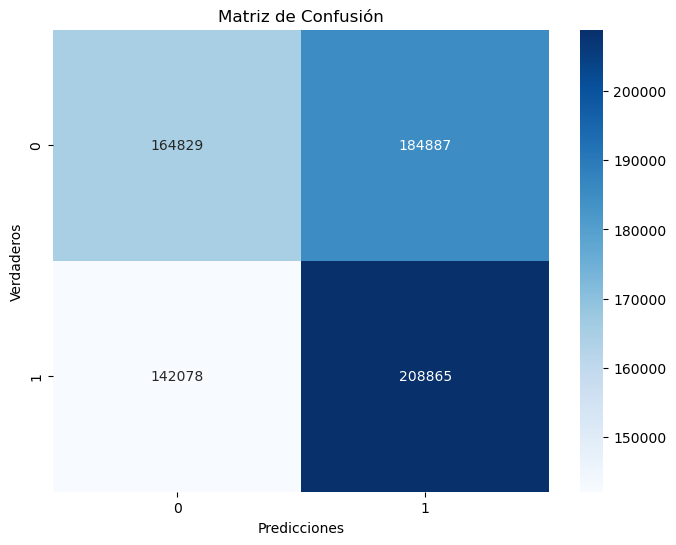

In [35]:
# Visualización opcional de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()